# Training a Basic CNN

In this task, we will build a classifier using CNN to learn and classify two image types. Since the image data is given in a numpy format, we will first load the data using numpy and examine the structure. Then, we will choose an appropriate CNN architecture to build and train the model for classification. Finally, we will evaluate the model accuracy and performance and adjust the design of the model where appropriate.

Keras with Tensorflow backend will be used in the task. 

First, import necessary packages for loading and processing the numpy datasets.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
import time

In [2]:
file_A = 'class_a.npy'
file_B = 'class_b.npy'
file_field = 'field.npy'

In [3]:
class_A = np.load(file_A)
class_B = np.load(file_B)
field = np.load(file_field)

In [4]:
#examine the shape of the numpy dataset
print(class_A.shape)
print(class_B.shape)
print(field.shape)

(1000, 40, 60)
(1000, 40, 60)
(200, 40, 60)


There are respectively 1000 sets of image for class A and class B, and 200 sets for field. The image size is 40 (row) x 60 (column).  Note that the image should be in single channel (c = 1), i.e. it is in grayscale.

We can then check the range of the pixel values of the image.

In [5]:
print(np.max(class_A), np.min(class_A))
print(np.max(class_B), np.min(class_B))
print(np.max(field), np.min(field))

1.0 0.0
1.0 0.0
1.0 0.0


The pixel value is between 0.0 and 1.0, which is ideal for neural network input. Hence no further rescaling of pixel value is necessary.

We can then plot some of the samples from class_A, class_B and field for examination.

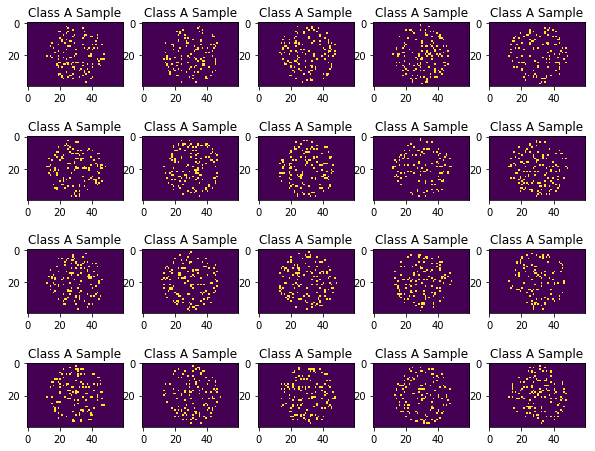

In [6]:
plt.rcParams['figure.figsize'] = (10.0,8.0)
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.title('Class A Sample')
    plt.imshow(class_A[i])

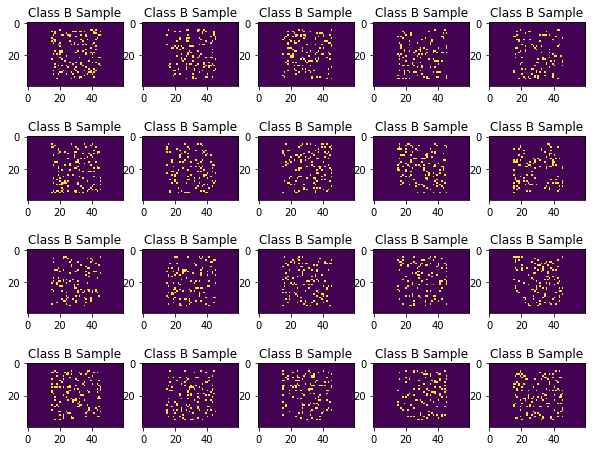

In [7]:
plt.rcParams['figure.figsize'] = (10.0,8.0)
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.title('Class B Sample')
    plt.imshow(class_B[i])

We can see that both datasets contain images of some dot patterns. In general, in *class_A* the distribution of the dots are more circular and for *class_B* more squarely. They may represent the states of the **Takoyaki (たこ焼き)** on the metal cooking mold?

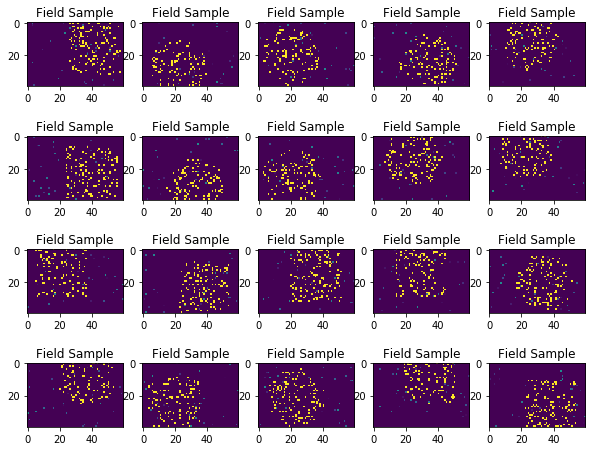

In [8]:
plt.rcParams['figure.figsize'] = (10.0,8.0)
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.title('Field Sample')
    plt.imshow(field[i])

The field dataset contains a mix of squarely and circular dot patterns and they are left for classification into class A and B. Note that the dots are not exactly distributed in the centre of the image but are shifted 

Since there are two outcomes of classifications (A or B), we can start working on the training dataset and the labels. We will combine the datasets, create the respective training labels (use 0 to denote class_A and 1 to denote class_B). Then we can reshuffle the combined dataset and divide it into training and test sets.

In [9]:
num, height, width = class_A.shape

In [10]:
# create combined datset and training labels (0 = class_A, 1 = class_B)
train_img = np.concatenate((class_A, class_B), axis=0)
train_label = np.zeros(num*2)  
train_label[num:] = 1

In [11]:
print(train_img.shape)

(2000, 40, 60)


In [12]:
print(train_label.shape)

(2000,)


In [13]:
# shuffle the image data and the respective labels randomly
np.random.seed(1234)

indices = np.random.permutation(train_img.shape[0])
train_img = train_img[indices]
train_label = train_label[indices]

[1. 0. 1. ... 1. 0. 0.]


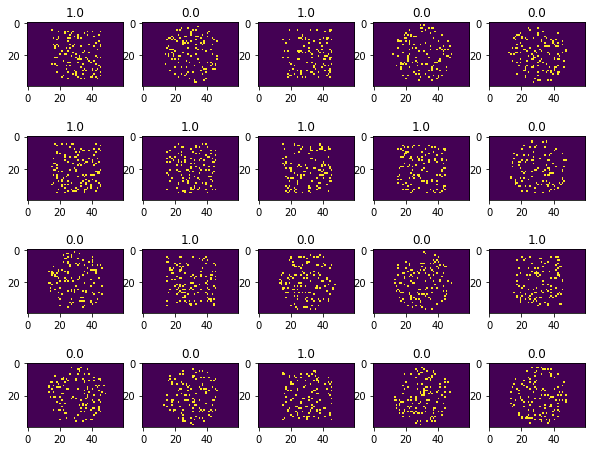

In [14]:
plt.rcParams['figure.figsize'] = (10.0,8.0)
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.title(train_label[i])
    plt.imshow(train_img[i])
    
print(train_label)

The image dataset is in single channel. We explicitly extend the dimension of the dataset along the last axis in order to create the dimension fit for the neural network. This will not alter the image data though.

In [15]:
train_img = np.expand_dims(train_img, axis = -1)

In [16]:
print(train_img.shape)

(2000, 40, 60, 1)


We also need one-hot vector encoding to the training label, i.e. 01 to denote 0 (class_A) and 10 to denote 1 (class B). 

In [17]:
from keras.utils import np_utils
# perform one-hot encoding to the train labels
train_label = np_utils.to_categorical(train_label)

Using TensorFlow backend.


In [18]:
print(train_label)

[[0. 1.]
 [1. 0.]
 [0. 1.]
 ...
 [0. 1.]
 [1. 0.]
 [1. 0.]]


Split the randomly shuffled dataset into train set (80% of the total images) and test set (remaining 20%) for training the CNN.

In [19]:
train_num = int(train_img.shape[0] * 0.8)

# split train and evaluation sets
x_Train = train_img[:train_num]
y_Train = train_label[:train_num]

x_Eval = train_img[train_num:]
y_Eval = train_label[train_num:]

In [20]:
print(x_Train.shape)
print(y_Train.shape)
print(x_Eval.shape)
print(y_Eval.shape)

(1600, 40, 60, 1)
(1600, 2)
(400, 40, 60, 1)
(400, 2)


We begin the building of CNN. First, import the necessary packages from Keras.

In [21]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard

In [26]:
# create helper function
def show_train_history(train_history, train, validation):
    plt.plot(train_history.history[train], color="orange")
    plt.plot(train_history.history[validation], color="blue")
    plt.title('Train History')
    plt.xlabel('Epochs')
    plt.ylabel(train)
    plt.show()

Construct a simple CNN with several convolution layers for feature extraction and fully connected layers for the classification outcome. We employ MaxPooling to reduce the dimension of the CNN layers for extraction of key features, and Dropout in the final fully-connected layer for reducing overfitting of training.

ReLU activation function is used throughout different stages of the CNN, and finally softmax for outputting the probabilities of each class.

In [23]:
# create model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = (height, width, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(2, activation = 'softmax'))

model.summary()

model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4), metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 38, 58, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 19, 29, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 27, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 13, 64)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 11, 64)         36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 3, 5, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 5, 64)          0         
__________

Then, start the training using the train dataset. The history of the training will be saved in train_history for model evaluation later.

Training is done using Nvidia GTX 1080 GPU with batch size of 128. It takes roughly 11 sec for running 40 epochs.

In [25]:
start_time = time.time()
train_history = model.fit(x_Train, y_Train, epochs=40, batch_size=128, validation_data=(x_Eval, y_Eval))
end_time = time.time()

print("Training is complete. Total time taken in {:.2f}sec.".format((end_time - start_time)))

Train on 1600 samples, validate on 400 samples
Epoch 1/40
1600/1600 [==============================] - 2s 1ms/step - loss: 0.6752 - acc: 0.6131 - val_loss: 0.6443 - val_acc: 0.8700
Epoch 2/40
1600/1600 [==============================] - 2s 1ms/step - loss: 0.6331 - acc: 0.7475 - val_loss: 0.5916 - val_acc: 0.9575
Epoch 3/40
1600/1600 [==============================] - 2s 1ms/step - loss: 0.5770 - acc: 0.8513 - val_loss: 0.5219 - val_acc: 0.9600
Epoch 4/40
1600/1600 [==============================] - 2s 1ms/step - loss: 0.5151 - acc: 0.8663 - val_loss: 0.4497 - val_acc: 0.9425
Epoch 5/40
1600/1600 [==============================] - 2s 1ms/step - loss: 0.4394 - acc: 0.9119 - val_loss: 0.3683 - val_acc: 0.9775
Epoch 6/40
1600/1600 [==============================] - 2s 1ms/step - loss: 0.3616 - acc: 0.9263 - val_loss: 0.2907 - val_acc: 0.9800
Epoch 7/40
1600/1600 [==============================] - 2s 1ms/step - loss: 0.2919 - acc: 0.9462 - val_loss: 0.2263 - val_acc: 0.9850
Epoch 8/40
1600

It seems that the model performs very well in the evaluation dataset (having 99% accuracy). Let's apply the model to the classification of the field dataset.

In [27]:
score = model.evaluate(x_Eval, y_Eval, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.01565800256677903
Test accuracy: 0.995


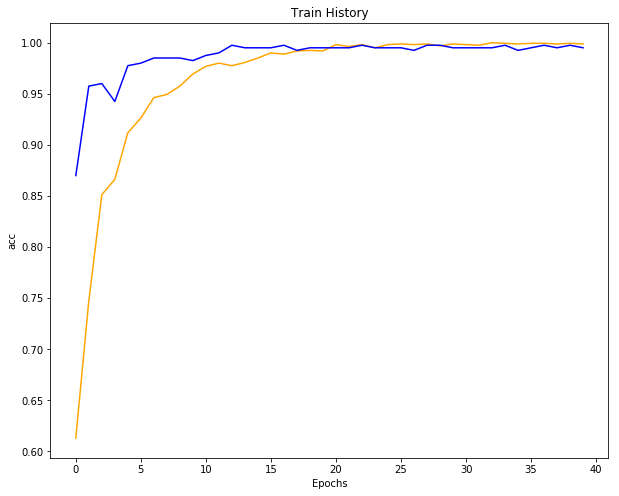

In [28]:
show_train_history(train_history, 'acc', 'val_acc')

Now it's time to test the classification on the field dataset. We align the field dataset into the dimension required by the model.

In [29]:
test_data = np.expand_dims(field, axis = -1)
print(test_data.shape)

(200, 40, 60, 1)


Now feed the field dataset into the model for classification .

In [30]:
predictions = model.predict(test_data)
predictions = np.argmax(predictions, axis=1)

In [31]:
print(predictions)

[1 0 0 1 0 1 1 0 0 0 0 1 1 1 0 0 0 0 1 1 1 0 0 0 0 0 1 1 1 0 0 0 1 1 0 0 0
 0 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 1 1 1
 1 1 1 1 0 1 0 0 0 1 1 1 0 1 0 1 0 0 1 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0
 1 1 0 0 1 0 0 0 1 0 0 0 1 1 0 0 0 0 1 1 0 0 0 1 1 1 0 0 0 1 0 0 1 0 1 1 1
 0 0 1 1 0 1 0 0 0 1 0 1 1 1 1 0 0 0 0 0 0 1 0 0 1 1 0 1 0 1 1 1 1 0 0 0 1
 0 0 1 1 0 0 1 1 1 0 0 1 0 0 0]


Let's combine the classification result with the actual images of the field dataset. Since we don't have the answer of the field data, we can only compare the result and the image for getting a rough idea of the accuracy of our model on field data.

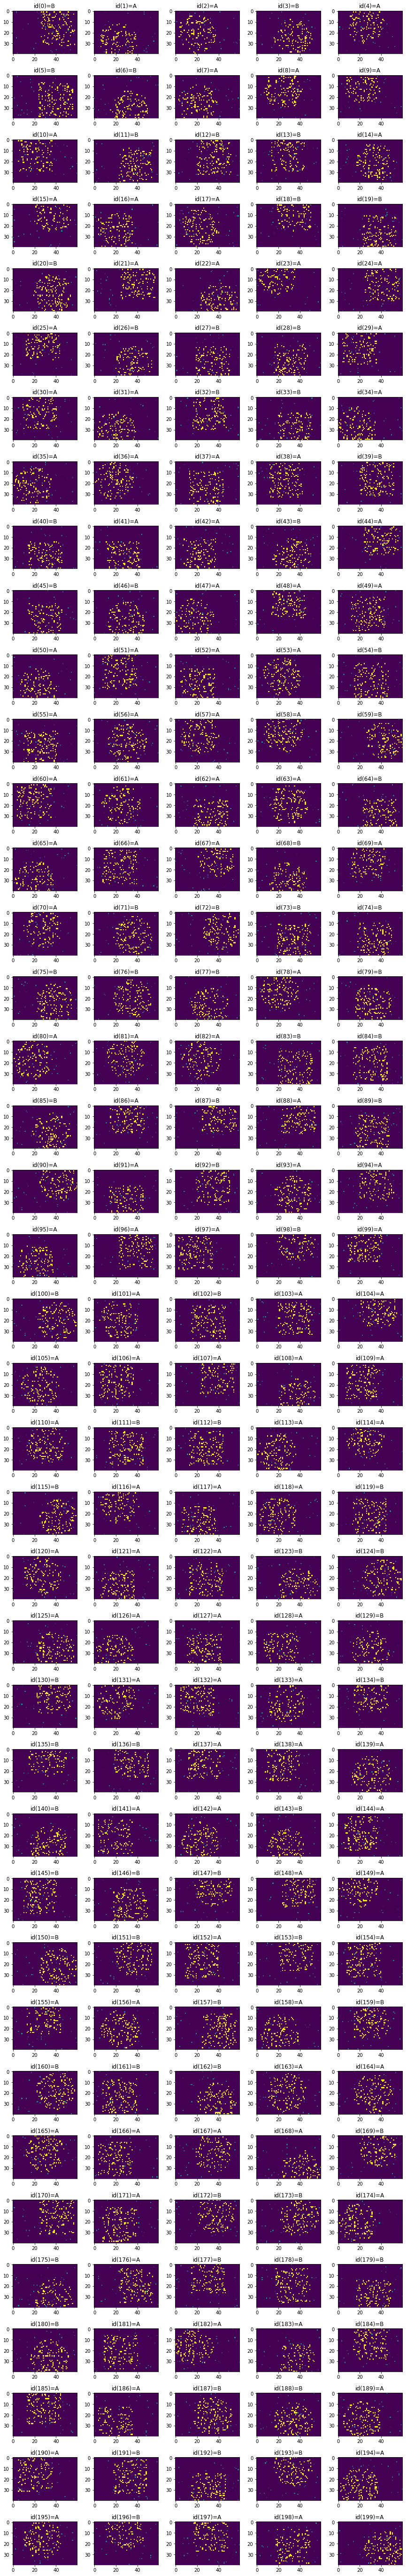

In [36]:
plt.rcParams['figure.figsize'] = (15.0,100.0)
for i in range(200):
    plt.subplot(40,5,i+1)
    if int(predictions[i]) == 1:
        ans = "B"
    else:
        ans = "A"
    plt.title("id("+str(i)+")="+ans)
    plt.imshow(field[i])
    plt.subplots_adjust(hspace=0.5)

We can see that, in the above figure, some images with squarely pattern have been classified as class A and some images with circular patterns have been classified as class B.

Examining the first 25 predictions, the following predictions look incorrect:
+ id(3): B
+ id(6): B
+ id(10): A
+ id(18): B
+ id(21): A
+ id(24): A

Hence, the error rate is about 6/25, i.e. the accuracy is roughly 74%. The accuracy of the real data is much lower than that of the training data of 99%. This is a typical case of ***over-fitting***.

The above performance of a simple CNN model serves as a baseline of our work. We will explore other measures to enhance the accuracy of the classification in real data in the coming sections, i.e. to reduce overfitting.

Before starting the next notebook, we may save the trained model weights.

In [33]:
model.save('model_basic.h5')